In [1]:
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from google.colab import drive

In [2]:
class image_data_set(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return {'data': self.data[index], 'label': self.labels[index]}

In [3]:
def get_image_tensor(file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = Image.open(file_path)
    return transform(image)
    
def get_data_sets(downloaded_data_dir, json_file_name): 
    json_file = open(downloaded_data_dir + json_file_name)
    coco_key = json.load(json_file)
    images = coco_key["images"]

    data, labels = [], []
    for index, image in enumerate(images):
        file_name = image["file_name"]
        file_path = downloaded_data_dir + file_name
        
        if os.path.isfile(file_path):
            label = coco_key["annotations"][index]["category_id"]
            try:
                image_tensor = get_image_tensor(file_path)
                data.append(image_tensor)
                labels.append(label)
            except:
                print("Truncated image encountered, leaving out of training and testing")
    
    training_data, testing_data, training_labels, testing_labels = train_test_split(data, labels, test_size = 0.20)
    
    print("\nNumber of training photos: " + str(len(training_data)))
    print("Number of testing photos: " + str(len(testing_data)))
    
    json_file.close()
    
    return training_data, testing_data, training_labels, testing_labels

In [4]:
def print_image(image_tensor, prediction, downloaded_data_dir, index):
    image_file_name = downloaded_data_dir + str(prediction.item()) + "_" + str(index) + ".png"
    
    #Alternative normalized RGB visualization: plt.imshow(image_tensor.cpu().permute(1, 2, 0).numpy())
    plt.imshow(image_tensor[0].cpu(), cmap="gray")
    plt.title("Incorrectly Predicted " + str(prediction.item()) + " Animals Present") 
    plt.show()
    #plt.imsave(image_file_name, image_tensor[0].cpu(), cmap="gray")

def print_testing_analysis(all_labels, all_predictions, title, downloaded_data_dir):
    subplot = plt.subplot()

    cf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cf_matrix = np.flip(cf_matrix, axis=0)
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Labels')
    subplot.set_title(title + ' Testing Confusion Matrix')
    subplot.xaxis.set_ticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    subplot.yaxis.set_ticklabels([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
    
    plot_file_name = downloaded_data_dir + title + "_Confusion_Matrix.png"
    #plt.savefig(plot_file_name)
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    print(title + " Accuracy: " + str(accuracy))

    precision, recall, f_score, support = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    print(title + " Precision: " + str(precision))
    print(title + " Recall: " + str(recall))
    print(title + " F-Score: " + str(f_score))

def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(training_loader):
        data, labels = data['data'].to(device), data['label'].to(device).float()
        optimizer.zero_grad()
        output = model(data).flatten()
        
        loss = criterion(output, labels)
        running_loss += loss.item()
        num_correct += (output.round() == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/len(training_loader.dataset)
    return loss, accuracy

def test(model, testing_loader, criterion, print_incorrect_images, downloaded_data_dir):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, data in enumerate(testing_loader):
        data, labels = data['data'].to(device), data['label'].to(device).float()
        output = model(data).flatten()
        
        loss = criterion(output, labels)
        running_loss += loss.item()
        for index, prediction in enumerate(output.round()):
            all_predictions.append(prediction.cpu().item())
            if(prediction == labels[index]):
                num_correct += 1
            elif(print_incorrect_images):
                print_image(data[index], prediction, downloaded_data_dir, i)

        all_labels.extend(labels.cpu())
    
    loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/len(testing_loader.dataset)
    return loss, accuracy, all_labels, all_predictions

In [5]:
def train_and_test(num_epochs, model, training_loader, testing_loader, device, criterion, downloaded_data_dir):    
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        print("Epoch: " + str(epoch))
        
        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        print("training loss: " + str(training_loss) + " and training accuracy: " + str(training_accuracy))
        
        testing_loss, testing_accuracy, _, _ = test(model, testing_loader, criterion, False, downloaded_data_dir)
        print("testing loss: " + str(testing_loss) + " and testing accuracy: " + str(testing_accuracy))

# Declaring Constants

In [6]:
num_epochs = 10
num_classes = 10
batch_size = 10
json_file_name = "animal_count_key.json"
downloaded_data_dir = "animal_count_manually_labeled_wildlife_data/"

print(torch.__version__)
print(torchvision.__version__)
print("torch.cuda.is_available(): " + str(torch.cuda.is_available()))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
criterion = nn.MSELoss()

2.0.0+cu118
0.15.1+cu118
torch.cuda.is_available(): True


# Loading Data

In [7]:
# Use this to connect to Google Drive in Google Colab
drive.mount('/content/drive')

# Use this to unzip file in Google Colab
!unzip -qq drive/MyDrive/animal_count_manually_labeled_wildlife_data

Mounted at /content/drive


In [8]:
training_data, testing_data, training_labels, testing_labels = get_data_sets(downloaded_data_dir, json_file_name)
training_data_set = image_data_set(training_data, training_labels)
testing_data_set = image_data_set(testing_data, testing_labels)
training_loader = DataLoader(dataset = training_data_set, batch_size = batch_size, shuffle = True)
testing_loader = DataLoader(dataset = testing_data_set, batch_size = batch_size, shuffle = True)


Number of training photos: 124
Number of testing photos: 32


# Declaring Models

In [9]:
resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, 1)

resnet152 = models.resnet152(weights = models.ResNet152_Weights.DEFAULT)
in_features = resnet152.fc.in_features
resnet152.fc = nn.Linear(in_features, 1)

vit_l_16 = models.vit_l_16(weights = models.ViT_L_16_Weights.DEFAULT)
in_features = vit_l_16.heads[0].in_features
vit_l_16.heads[0] = nn.Linear(in_features, 1)

if torch.cuda.device_count() > 1:
    print("Multiple GPUs available, using: " + str(torch.cuda.device_count()))
    resnet50 = nn.DataParallel(resnet50)
    resnet152 = nn.DataParallel(resnet152)
    vit_l_16 = nn.DataParallel(vit_l_16)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 310MB/s]
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 90.6MB/s]
Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [01:07<00:00, 18.1MB/s]


# Training

In [10]:
print("\nTraining and Testing ResNet50")
train_and_test(num_epochs, resnet50, training_loader, testing_loader, device, criterion, downloaded_data_dir)

print("\nTraining and Testing ResNet152")
train_and_test(num_epochs, resnet152, training_loader, testing_loader, device, criterion, downloaded_data_dir)

print("\nTraining and Testing ViT Large 16")
train_and_test(num_epochs, vit_l_16, training_loader, testing_loader, device, criterion, downloaded_data_dir)


Training and Testing ResNet50
Epoch: 0
training loss: 0.03883391636754236 and training accuracy: 0.7741935483870968
testing loss: 0.03354976652190089 and testing accuracy: 0.84375
Epoch: 1
training loss: 0.024282467371273424 and training accuracy: 0.8306451612903226
testing loss: 0.011309688503388315 and testing accuracy: 0.8125
Epoch: 2
training loss: 0.021323866845529164 and training accuracy: 0.8548387096774194
testing loss: 0.0944261911790818 and testing accuracy: 0.71875
Epoch: 3
training loss: 0.017435878282412887 and training accuracy: 0.8709677419354839
testing loss: 0.009659273608122021 and testing accuracy: 0.9375
Epoch: 4
training loss: 0.008609122701830441 and training accuracy: 0.9274193548387096
testing loss: 0.007781760970829055 and testing accuracy: 0.9375
Epoch: 5
training loss: 0.007663978646779733 and training accuracy: 0.9435483870967742
testing loss: 0.005782416610600194 and testing accuracy: 0.90625
Epoch: 6
training loss: 0.006577879378211594 and training accura

# Final Testing

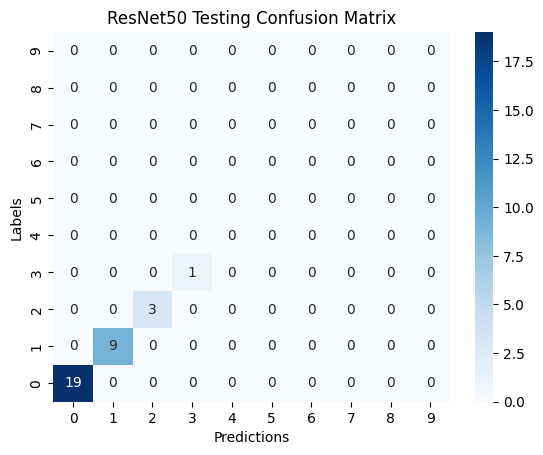

ResNet50 Accuracy: 1.0
ResNet50 Precision: 1.0
ResNet50 Recall: 1.0
ResNet50 F-Score: 1.0


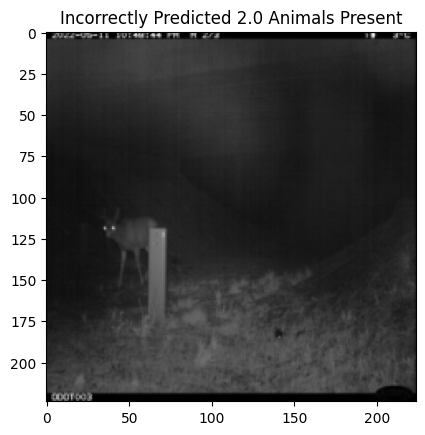

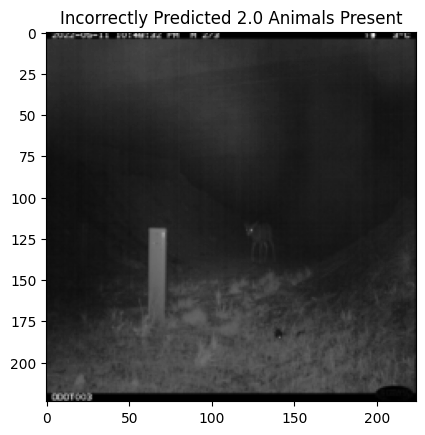

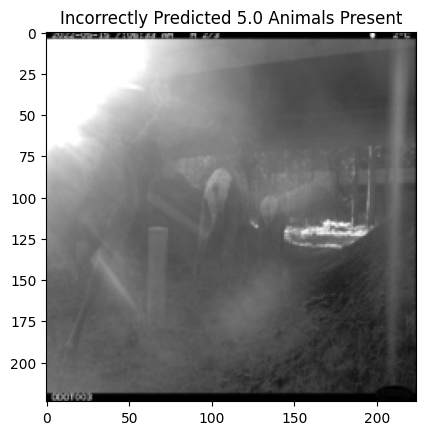

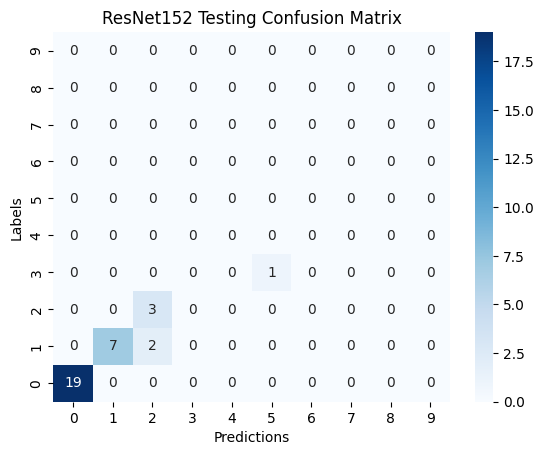

ResNet152 Accuracy: 0.90625
ResNet152 Precision: 0.93125
ResNet152 Recall: 0.90625
ResNet152 F-Score: 0.91015625


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


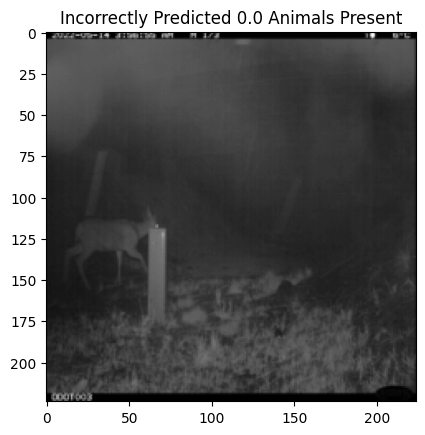

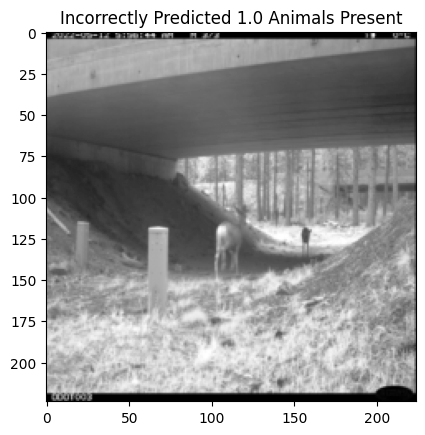

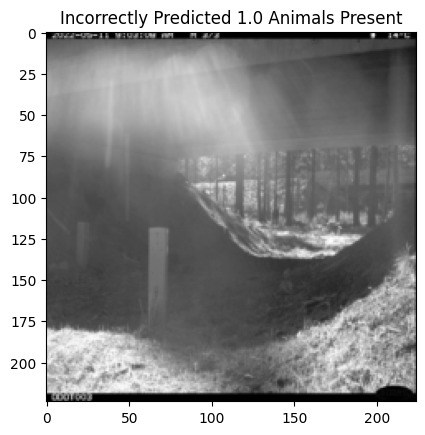

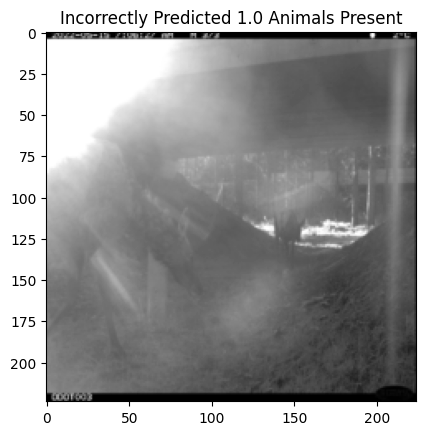

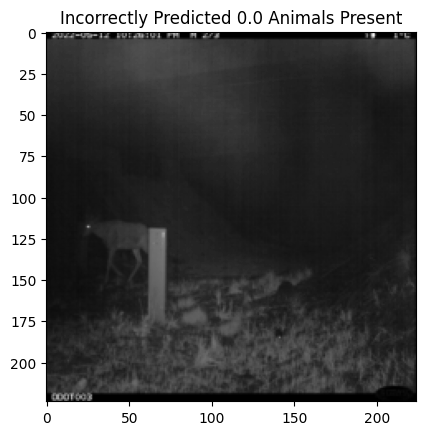

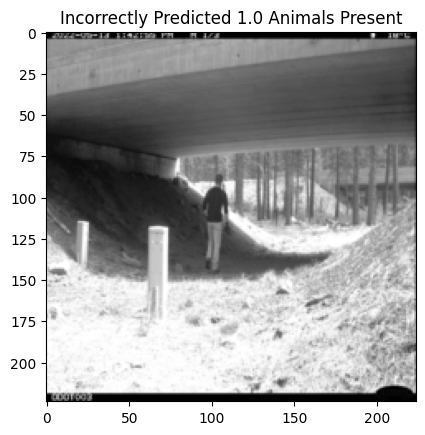

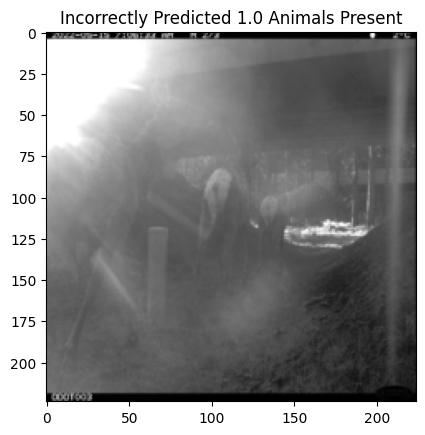

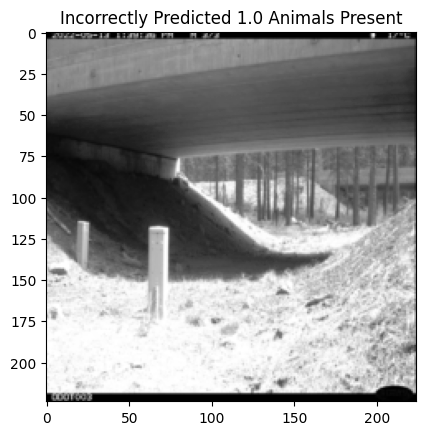

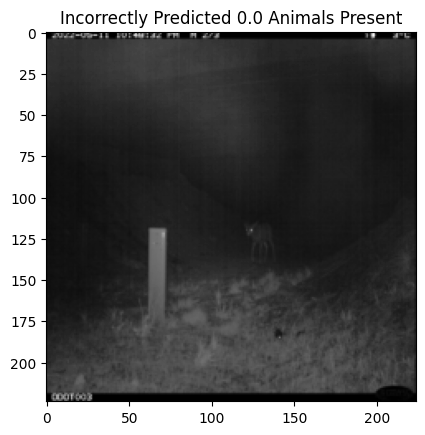

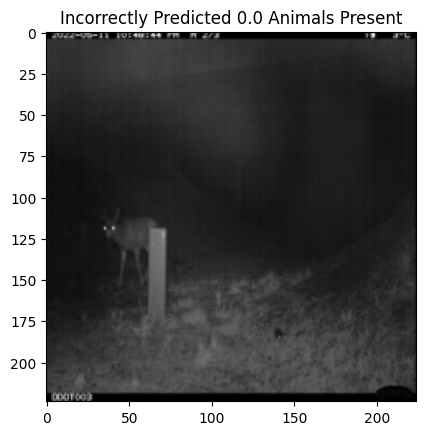

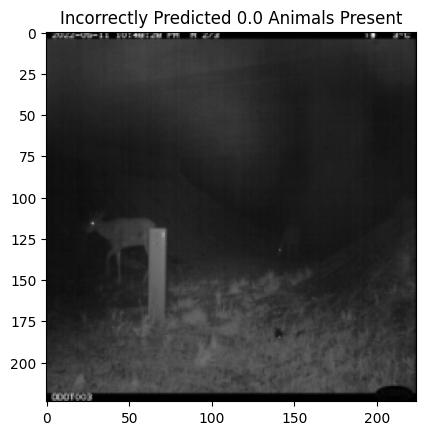

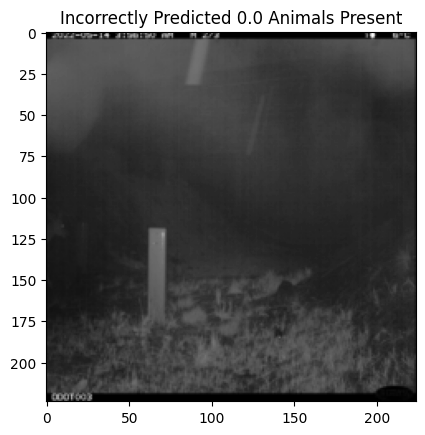

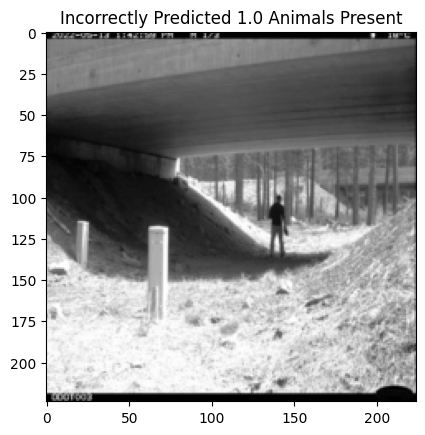

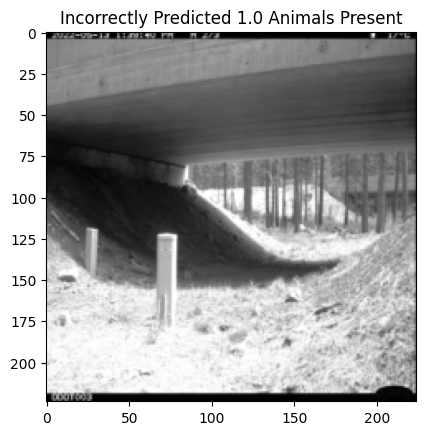

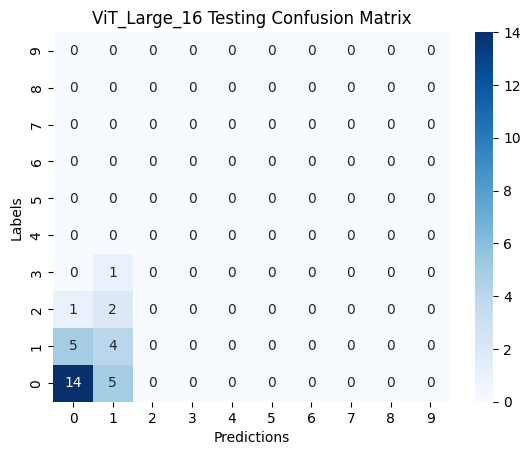

ViT_Large_16 Accuracy: 0.5625
ViT_Large_16 Precision: 0.5093749999999999
ViT_Large_16 Recall: 0.5625
ViT_Large_16 F-Score: 0.5334249084249084


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
testing_loss, testing_accuracy, labels, predictions = test(resnet50, testing_loader, criterion, True, downloaded_data_dir)
print_testing_analysis(labels, predictions, "ResNet50", downloaded_data_dir)

testing_loss, testing_accuracy, labels, predictions = test(resnet152, testing_loader, criterion, True, downloaded_data_dir)
print_testing_analysis(labels, predictions, "ResNet152", downloaded_data_dir)

testing_loss, testing_accuracy, labels, predictions = test(vit_l_16, testing_loader, criterion, True, downloaded_data_dir)
print_testing_analysis(labels, predictions, "ViT_Large_16", downloaded_data_dir)